# Tracer data curation
This notebook describes setting up of tracer data for use with OLPROC. Four tracer species were injected into the aquifer: Fluorescein, Eosine, Rhodamine WT and Sulforhodamine B.

## Background
Tracer data has been collected using GAC samplers (granular activated carbon). The samplers have been installed in monitoring wells (`column datetime_placed`) and collected after an interval of time (`column datetime_collected`).

Measured concentrations (in ppb) should be regarded as an accumulated concentration between `datetime_placed` and `datetime_collected`. The number of days between the two dates are recorded in the column `exposure_time_days`.

After initiation of the tracer experiment, it was discovered that another consultant had, on behalf of the municipality, injected Fluorescein into the sewer system to investigate possible sewer leakage. Upon a baseline measurement by Nirás (`column monitoring_round == BASELINE`), an initial concentration of Fluorescein were discovered in a number of wells.

In [130]:
import os
import numpy as np
import pandas as pd
import pyemu
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})

In [131]:
data_dir = os.path.join('..', '..', 'data', 'raw_data', 'tracer')
assert(data_dir)

In [132]:
os.listdir(data_dir)

['readme.md',
 'Tracerdata_2021-05-20.xlsx',
 'tracer_gacbor_filter.csv',
 'tracer_gacbor_filter.xlsx',
 '~$Tracerdata_2021-05-20.xlsx',
 '~$tracer_gacbor_filter.xlsx']

In [133]:
df = pd.read_excel(os.path.join(data_dir, 'tracer_gacbor_filter.xlsx'))
display(df)

,oul_no,station_no,station_name,datetime_placed,datetime_collected,fluorescein_conc_ppb,eosine_conc_ppb,rwt_conc_ppb,srb_conc_ppb,monitoring_round,exposure_time_days,comments
0,B7756,12,B15-1,2016-09-06 12:02:00,2016-09-09 14:10:00,NaN,NaN,NaN,NaN,BASELINE 1,3,NaN
1,B8798,12,B15-1,2016-09-09 14:10:00,2016-11-10 08:30:00,NaN,NaN,NaN,NaN,BASELINE 2,62,NaN
2,B9117,12,B15-1,2016-11-09 00:00:00,2016-12-06 09:30:00,NaN,NaN,NaN,NaN,ROUND 2,27,NaN
3,C0167,12,B15-1,2016-12-06 00:00:00,2017-01-24 08:20:00,NaN,NaN,NaN,NaN,ROUND 4,49,NaN
4,B7757,13,NI1401-2,2016-09-06 16:15:00,2016-09-09 13:20:00,NaN,NaN,NaN,NaN,BASELINE 1,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
396,D8782,141,B9-2,2018-11-07 00:00:00,2019-10-09 11:23:00,NaN,NaN,29.8,NaN,ROUND 32,336,NaN
397,D8783,143,B9-4,2018-11-07 00:00:00,2019-10-09 11:26:00,NaN,NaN,41.1,NaN,ROUND 32,336,NaN
398,D8784,145,B10-1,2018-11-07 00:00:00,2019-10-09 10:55:00,NaN,2.79,NaN,NaN,ROUND 32,336,NaN
399,D8785,146,B10-2,2018-11-07 00:00:00,2019-10-09 11:00:00,NaN,30.50,NaN,2.67,ROUND 32,336,NaN


Make sure datetime columns are of datetime data-type:

In [134]:
df['datetime_placed'] = pd.to_datetime(df['datetime_placed'])
df['datetime_collected'] = pd.to_datetime(df['datetime_collected'])

Sort values based on station name and date collected:

In [135]:
df = df.sort_values(['station_name', 'datetime_collected']).reset_index(drop=True)
display(df)

,oul_no,station_no,station_name,datetime_placed,datetime_collected,fluorescein_conc_ppb,eosine_conc_ppb,rwt_conc_ppb,srb_conc_ppb,monitoring_round,exposure_time_days,comments
0,D8784,145,B10-1,2018-11-07 00:00:00,2019-10-09 10:55:00,NaN,2.79,NaN,NaN,ROUND 32,336,NaN
1,D8785,146,B10-2,2018-11-07 00:00:00,2019-10-09 11:00:00,NaN,30.50,NaN,2.67,ROUND 32,336,NaN
2,D8786,148,B10-4,2018-11-07 00:00:00,2019-10-09 11:05:00,NaN,121.00,NaN,NaN,ROUND 32,336,NaN
3,B7756,12,B15-1,2016-09-06 12:02:00,2016-09-09 14:10:00,NaN,NaN,NaN,NaN,BASELINE 1,3,NaN
4,B8798,12,B15-1,2016-09-09 14:10:00,2016-11-10 08:30:00,NaN,NaN,NaN,NaN,BASELINE 2,62,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
396,D3413,124,NI1707-1,2018-08-28 00:00:00,2018-11-07 00:00:00,NaN,NaN,112.0,NaN,ROUND 25,71,NaN
397,D8772,124,NI1707-1,2018-11-07 00:00:00,2019-10-10 11:30:00,NaN,NaN,134.0,NaN,ROUND 32,337,NaN
398,C9188,113,NI1712-1,2017-08-04 00:00:00,2018-03-14 00:00:00,NaN,NaN,NaN,NaN,ROUND 18,222,NaN
399,D3405,113,NI1712-1,2018-03-14 00:00:00,2018-11-08 00:00:00,NaN,NaN,NaN,NaN,ROUND 25,239,NaN


Fill NaN with 0 to indicate a concentration below detection limits:

In [136]:
df = df.fillna(0)
display(df)

,oul_no,station_no,station_name,datetime_placed,datetime_collected,fluorescein_conc_ppb,eosine_conc_ppb,rwt_conc_ppb,srb_conc_ppb,monitoring_round,exposure_time_days,comments
0,D8784,145,B10-1,2018-11-07 00:00:00,2019-10-09 10:55:00,0.0,2.79,0.0,0.00,ROUND 32,336,0
1,D8785,146,B10-2,2018-11-07 00:00:00,2019-10-09 11:00:00,0.0,30.50,0.0,2.67,ROUND 32,336,0
2,D8786,148,B10-4,2018-11-07 00:00:00,2019-10-09 11:05:00,0.0,121.00,0.0,0.00,ROUND 32,336,0
3,B7756,12,B15-1,2016-09-06 12:02:00,2016-09-09 14:10:00,0.0,0.00,0.0,0.00,BASELINE 1,3,0
4,B8798,12,B15-1,2016-09-09 14:10:00,2016-11-10 08:30:00,0.0,0.00,0.0,0.00,BASELINE 2,62,0
...,...,...,...,...,...,...,...,...,...,...,...,...
396,D3413,124,NI1707-1,2018-08-28 00:00:00,2018-11-07 00:00:00,0.0,0.00,112.0,0.00,ROUND 25,71,0
397,D8772,124,NI1707-1,2018-11-07 00:00:00,2019-10-10 11:30:00,0.0,0.00,134.0,0.00,ROUND 32,337,0
398,C9188,113,NI1712-1,2017-08-04 00:00:00,2018-03-14 00:00:00,0.0,0.00,0.0,0.00,ROUND 18,222,0
399,D3405,113,NI1712-1,2018-03-14 00:00:00,2018-11-08 00:00:00,0.0,0.00,0.0,0.00,ROUND 25,239,0


In [137]:
df.station_name.unique()

array(['B10-1', 'B10-2', 'B10-4', 'B15-1', 'B2-1', 'B2-2', 'B2-3', 'B29',
       'B34', 'B35', 'B36', 'B37', 'B38-1', 'B8-1', 'B8-2', 'B9-1',
       'B9-2', 'B9-4', 'KB1-1', 'KB1-2', 'KB4-1', 'KB4-2', 'KB4-3',
       'KB4-4', 'NI1401-1', 'NI1401-2', 'NI1402-1', 'NI1402-2',
       'NI1405-2', 'NI1406', 'NI1407-2', 'NI1407-3', 'NI1408-2',
       'NI1408-3', 'NI1412-1', 'NI1412-2', 'NI1412-3', 'NI1413-1',
       'NI1413-2', 'NI1413-3', 'NI1501-1', 'NI1501-2', 'NI1501-3',
       'NI1601-1', 'NI1601-2', 'NI1601-3', 'NI1603-2', 'NI1604-3',
       'NI1605-1', 'NI1606-1', 'NI1606-2', 'NI1606-3', 'NI1607-1',
       'NI1607-3', 'NI1608-1', 'NI1608-3', 'NI1609-1', 'NI1609-2',
       'NI1609-3', 'NI1610-1', 'NI1611-1', 'NI1612-1', 'NI1612-2',
       'NI1701-1', 'NI1702-2', 'NI1703-1', 'NI1703-2', 'NI1704-1',
       'NI1704-2', 'NI1705-1', 'NI1705-2', 'NI1706-1', 'NI1706-2',
       'NI1707-1', 'NI1712-1'], dtype=object)

### Visualize the data

Because there are so many sites and not all of them have detected all (or any) of the tracers, let's create lists for each tracer containing only sites where concentrations are detected (just to prevent cluttered plots and make it easier to view the data):

In [138]:
fluorescein_detected = []
eosine_detected = []
rwt_detected = []
srb_detected = []

Append the name of the sites where a concentration is detected for each corresponding site and tracer element:

In [139]:
#Fluorescein
for site in df.station_name.unique():
    if any(i > 0 for i in df.loc[df['station_name'] == site]['fluorescein_conc_ppb']):
        fluorescein_detected.append(site)
print(fluorescein_detected)

['B35', 'B36', 'KB1-1', 'KB1-2', 'KB4-2', 'KB4-3', 'KB4-4', 'NI1405-2', 'NI1408-2', 'NI1408-3', 'NI1412-1', 'NI1412-2', 'NI1501-1', 'NI1605-1', 'NI1705-1', 'NI1705-2', 'NI1706-1']


In [140]:
#Eosine
for site in df.station_name.unique():
    if any(i > 0 for i in df.loc[df['station_name'] == site]['eosine_conc_ppb']):
        eosine_detected.append(site)
print(eosine_detected)

['B10-1', 'B10-2', 'B10-4', 'B36', 'KB1-1', 'KB1-2', 'NI1412-1', 'NI1607-1', 'NI1610-1', 'NI1611-1', 'NI1612-1', 'NI1612-2', 'NI1703-2']


In [141]:
#RWT
for site in df.station_name.unique():
    if any(i > 0 for i in df.loc[df['station_name'] == site]['rwt_conc_ppb']):
        rwt_detected.append(site)
print(rwt_detected)

['B9-2', 'B9-4', 'KB4-2', 'KB4-3', 'KB4-4', 'NI1406', 'NI1501-1', 'NI1501-2', 'NI1606-1', 'NI1704-1', 'NI1705-1', 'NI1705-2', 'NI1706-1', 'NI1706-2', 'NI1707-1']


In [142]:
#SRB
for site in df.station_name.unique():
    if any(i > 0 for i in df.loc[df['station_name'] == site]['srb_conc_ppb']):
        srb_detected.append(site)
print(srb_detected)

['B10-2', 'B34', 'B37', 'KB1-1', 'KB1-2', 'NI1412-3', 'NI1413-3', 'NI1601-1', 'NI1601-2', 'NI1601-3', 'NI1603-2', 'NI1606-2', 'NI1607-1', 'NI1611-1', 'NI1612-1', 'NI1612-2', 'NI1701-1', 'NI1702-2', 'NI1703-2']


Function for plotting data:

In [143]:
def plot_tracerdata(sites_list, tracer_col):
    ncols = 3
    nrows = int(np.ceil(len(sites_list) / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12,20), sharex=True)

    for index, site in enumerate(sites_list):
        x = df.loc[df['station_name'] == site]['datetime_collected']
        y = df.loc[df['station_name'] == site][tracer_col]
        s = df.loc[df['station_name'] == site]['exposure_time_days']
        axes.flat[index].scatter(x, y, s=s, label=site)
        axes.flat[index].plot(x, y, label=site)
        axes.flat[index].title.set_text(site)

    for col in axes:
        for i in range(3):
            col[i].tick_params(axis='x', labelrotation=90)

    plt.tight_layout()

### Plotting

Marker size is determined by the number of days between `datetime_placed` and `datetime_collected`, i.e. colum `exposure_time_days` .

#### Plot Fluoresceine concentration:

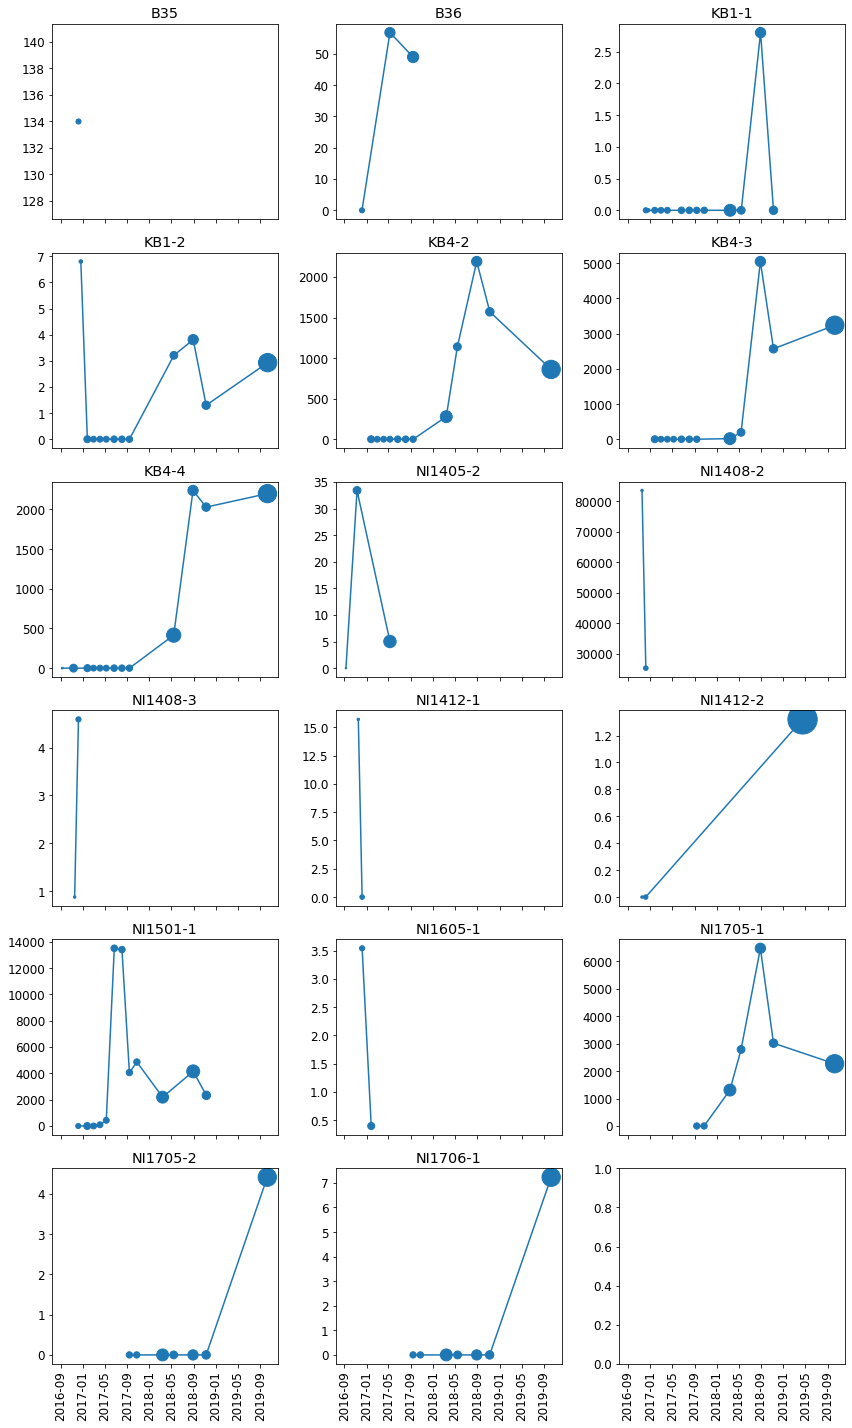

In [144]:
plot_tracerdata(fluorescein_detected, 'fluorescein_conc_ppb')

#### Plot Eosine concentrations:

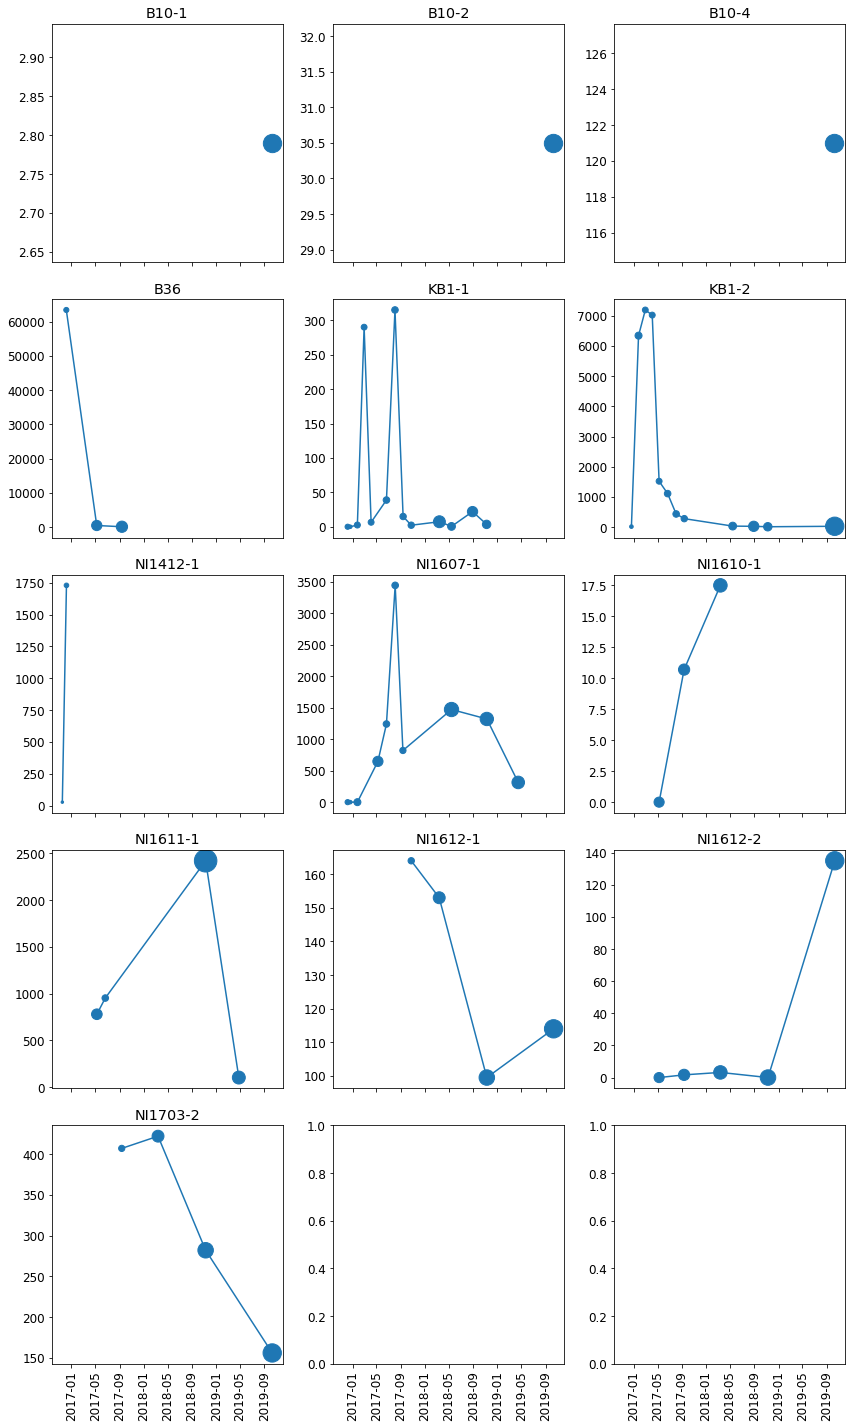

In [145]:
plot_tracerdata(eosine_detected, 'eosine_conc_ppb')

#### Plot Rhodamine WT concentrations:

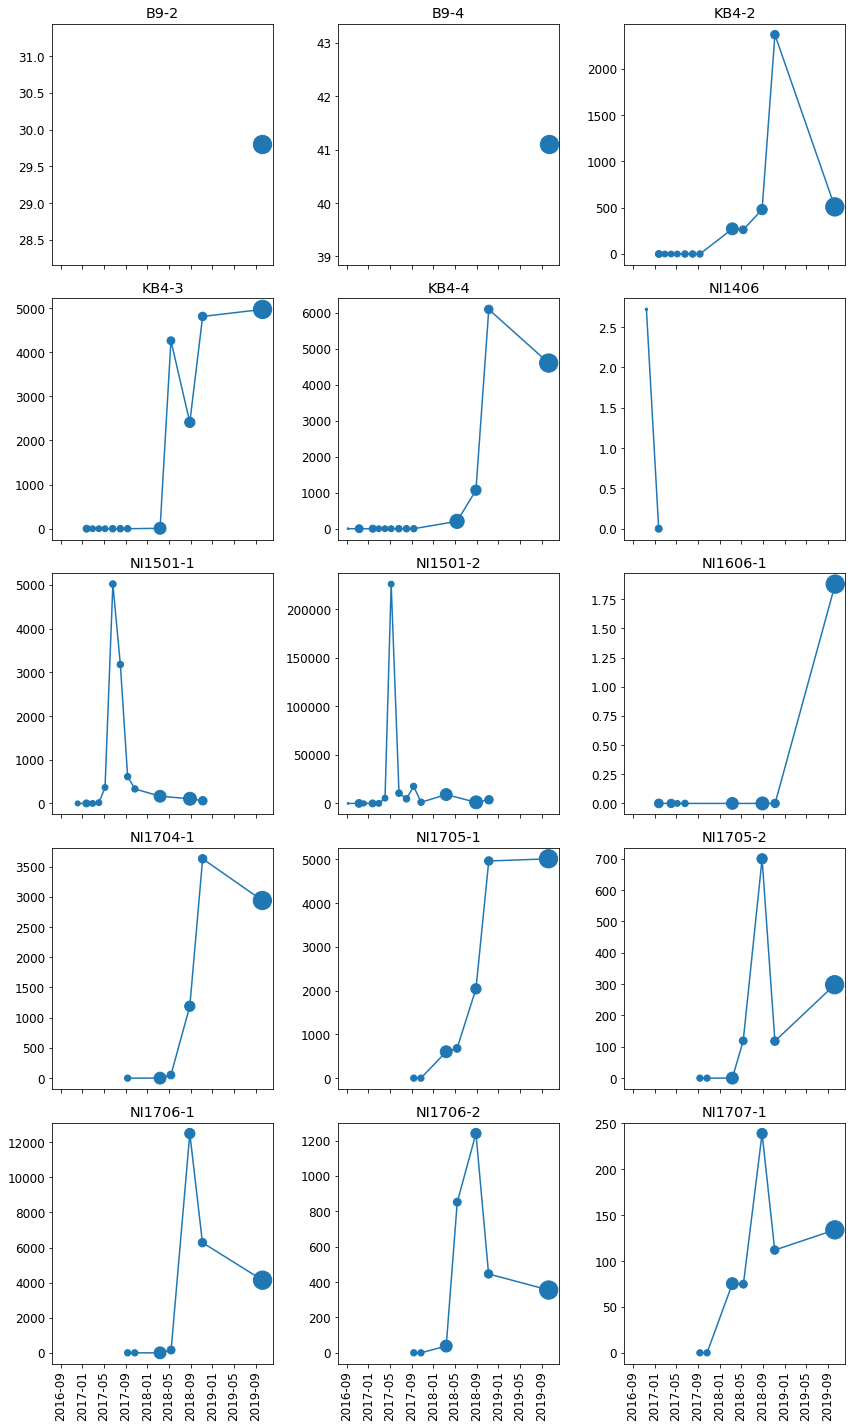

In [146]:
plot_tracerdata(rwt_detected, 'rwt_conc_ppb')

#### Plot Sulforhodamine B concentrations:

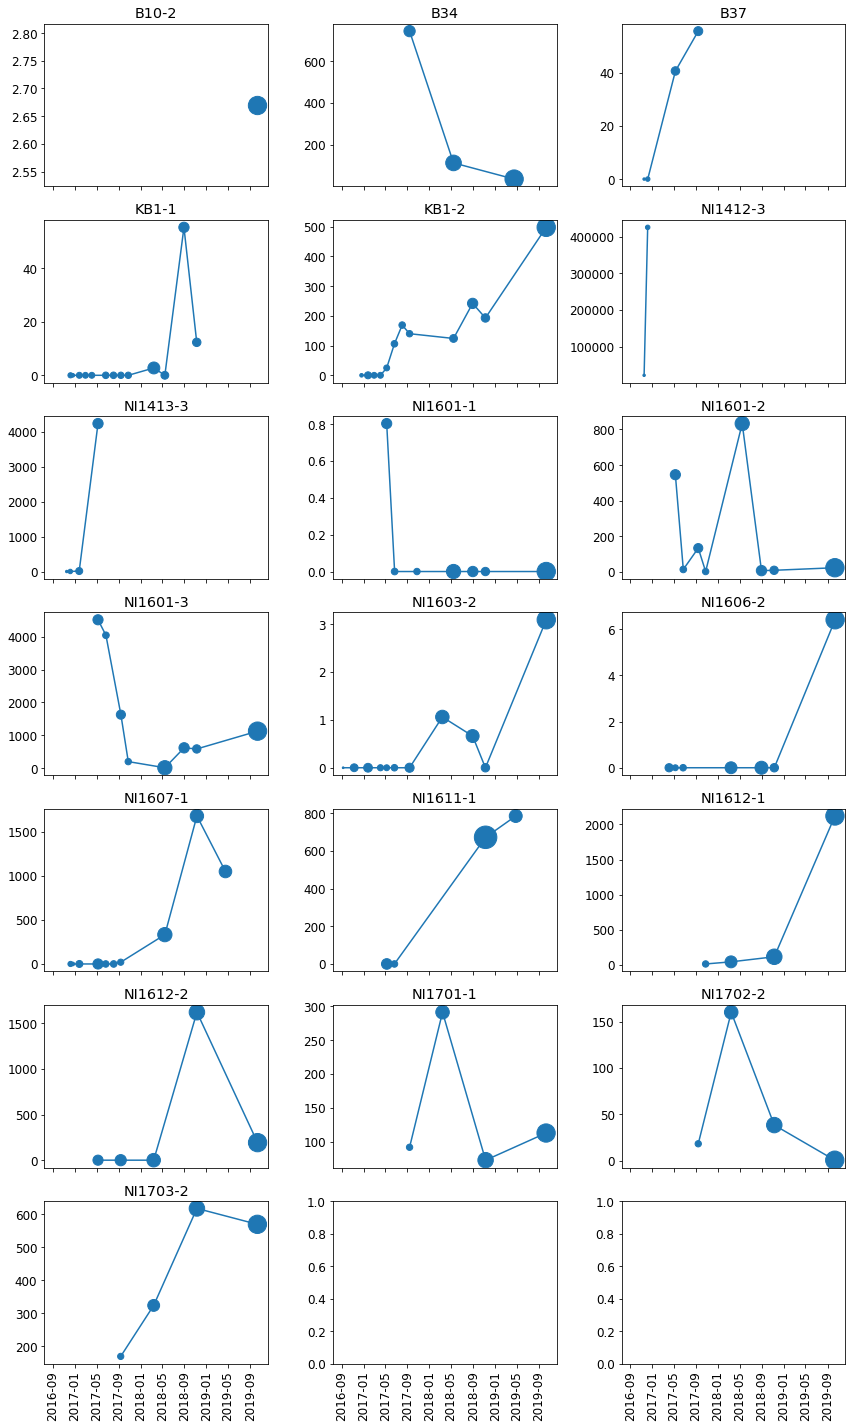

In [147]:
plot_tracerdata(srb_detected, 'srb_conc_ppb')

In [148]:
display(df)

,oul_no,station_no,station_name,datetime_placed,datetime_collected,fluorescein_conc_ppb,eosine_conc_ppb,rwt_conc_ppb,srb_conc_ppb,monitoring_round,exposure_time_days,comments
0,D8784,145,B10-1,2018-11-07 00:00:00,2019-10-09 10:55:00,0.0,2.79,0.0,0.00,ROUND 32,336,0
1,D8785,146,B10-2,2018-11-07 00:00:00,2019-10-09 11:00:00,0.0,30.50,0.0,2.67,ROUND 32,336,0
2,D8786,148,B10-4,2018-11-07 00:00:00,2019-10-09 11:05:00,0.0,121.00,0.0,0.00,ROUND 32,336,0
3,B7756,12,B15-1,2016-09-06 12:02:00,2016-09-09 14:10:00,0.0,0.00,0.0,0.00,BASELINE 1,3,0
4,B8798,12,B15-1,2016-09-09 14:10:00,2016-11-10 08:30:00,0.0,0.00,0.0,0.00,BASELINE 2,62,0
...,...,...,...,...,...,...,...,...,...,...,...,...
396,D3413,124,NI1707-1,2018-08-28 00:00:00,2018-11-07 00:00:00,0.0,0.00,112.0,0.00,ROUND 25,71,0
397,D8772,124,NI1707-1,2018-11-07 00:00:00,2019-10-10 11:30:00,0.0,0.00,134.0,0.00,ROUND 32,337,0
398,C9188,113,NI1712-1,2017-08-04 00:00:00,2018-03-14 00:00:00,0.0,0.00,0.0,0.00,ROUND 18,222,0
399,D3405,113,NI1712-1,2018-03-14 00:00:00,2018-11-08 00:00:00,0.0,0.00,0.0,0.00,ROUND 25,239,0
